# MLP
Training auf IDS18 80%  
Validierung auf IDS18 10%   
Test auf IDS18 10%  
Test auf IDS17 folgt in nächstem Skript

In [15]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [16]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='31_cnn.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
ids17_prep_1 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet_prep_1/ids17.parquet'
ids18_prep_1 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet_prep_1/ids18.parquet'
hybrid_train_prep_1 =  '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_train.parquet'
hybrid_test_prep_1 = '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_test.parquet'

### Laden des Datensatzes

In [17]:
# Datensatz einlesen für Training 80%, Validierung 10% und Test 10%
df = pd.read_parquet(ids18_prep_1)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))
print(df.shape)
print(df.columns)

2024-11-20 12:07:43 - INFO - Class distribution
Label
BENIGN                          2967676
DoS Hulk                        1803160
DDoS-LOIC-HTTP                   289328
Botnet Ares                      142921
SSH-BruteForce                    94197
Infiltration - NMAP Portscan      89374
DoS GoldenEye                     22560
DoS Slowloris                      8490
Name: count, dtype: int64


(5417706, 52)
Index(['Fwd IAT Total', 'Dst Port', 'FIN Flag Count', 'Packet Length Variance',
       'Down/Up Ratio', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'URG Flag Count', 'Bwd Packets/s', 'Total TCP Flow Time',
       'Bwd Bulk Rate Avg', 'Total Length of Fwd Packet', 'Bwd IAT Mean',
       'Bwd Packet/Bulk Avg', 'Fwd IAT Max', 'Protocol', 'Flow IAT Min',
       'Bwd Header Length', 'Active Max', 'Total Fwd Packet',
       'Subflow Bwd Packets', 'Fwd Header Length', 'Fwd Seg Size Min',
       'Fwd RST Flags', 'Idle Std', 'Fwd Packet Length Min',
       'Bwd Init Win Bytes', 'Bwd Packet Length Std', 'RST Flag Count',
       'Fwd Act Data Pkts', 'Subflow Fwd Packets', 'ECE Flag Count',
       'SYN Flag Count', 'Bwd URG Flags', 'Average Packet Size', 'Bwd IAT Max',
       'Bwd PSH Flags', 'Total Length of Bwd Packet', 'Bwd RST Flags',
       'Flow Bytes/s', 'Fwd Bulk Rate Avg', 'Fwd IAT Min', 'Active Std',
       'Packet Length Max', 'Bwd IAT Total', 'Fwd IAT Mean',

### Trennen von Features und Labels

In [18]:
X = df.iloc[:, :-1]  # Alle Spalten außer der letzten
print("Form von X:", X.shape)
y = df.iloc[:, -1]   # Die letzte Spalte
print("Form von y:", y.shape)


Form von X: (5417706, 51)
Form von y: (5417706,)


### Label Encoding für y

In [19]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Einzigartige Labels:", label_encoder.classes_)
print("Kodierte Labels:", np.unique(y_encoded))

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce']
Kodierte Labels: [0 1 2 3 4 5 6 7]


### Aufteilen der Daten in Trainings-, Validierungs- und Testdatensätze

In [20]:
# Aufteilen in Trainings- und temporäre Datensätze
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded)

# Aufteilen in Validierungs- und Testdaten
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Form von X_train:", X_train.shape)
print("Form von X_val:", X_val.shape)
print("Form von X_test:", X_test.shape)


Form von X_train: (4334164, 51)
Form von X_val: (541771, 51)
Form von X_test: (541771, 51)


### Skallierung von X

In [21]:
# Skalieren der Daten
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit auf Trainingsdaten
X_val_scaled = scaler.transform(X_val)         # Transform auf Val.-Daten
X_test_scaled = scaler.transform(X_test)       # Transform auf Testdaten

### Überprüfen der Klassenverteilung

In [22]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_train, "Trainingsdatensatz")
print_class_distribution(y_val, "Validierungsdatensatz")
print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Trainingsdatensatz:
  Klasse 0: 2374140 Beispiele (54.78%)
  Klasse 1: 114337 Beispiele (2.64%)
  Klasse 2: 231462 Beispiele (5.34%)
  Klasse 3: 18048 Beispiele (0.42%)
  Klasse 4: 1442528 Beispiele (33.28%)
  Klasse 5: 6792 Beispiele (0.16%)
  Klasse 6: 71499 Beispiele (1.65%)
  Klasse 7: 75358 Beispiele (1.74%)

Klassenverteilung in Validierungsdatensatz:
  Klasse 0: 296768 Beispiele (54.78%)
  Klasse 1: 14292 Beispiele (2.64%)
  Klasse 2: 28933 Beispiele (5.34%)
  Klasse 3: 2256 Beispiele (0.42%)
  Klasse 4: 180316 Beispiele (33.28%)
  Klasse 5: 849 Beispiele (0.16%)
  Klasse 6: 8937 Beispiele (1.65%)
  Klasse 7: 9420 Beispiele (1.74%)

Klassenverteilung in Testdatensatz:
  Klasse 0: 296768 Beispiele (54.78%)
  Klasse 1: 14292 Beispiele (2.64%)
  Klasse 2: 28933 Beispiele (5.34%)
  Klasse 3: 2256 Beispiele (0.42%)
  Klasse 4: 180316 Beispiele (33.28%)
  Klasse 5: 849 Beispiele (0.16%)
  Klasse 6: 8938 Beispiele (1.65%)
  Klasse 7: 9419 Beispiele (1.74%)



 ### Modell erstellen und trainieren

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
num_features = 51  # Anzahl der Spalten in X_scaled
num_classes = len(label_encoder.classes_)  # Anzahl der Klassen

# Definiere das Modell
model = Sequential([
    InputLayer(input_shape=(num_features,)),  # Eingabeschicht
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Erste versteckte Schicht mit l2
    #Dense(64, input_dim=num_features, activation='relu'),  # Erste versteckte Schicht ohne l2
    Dropout(0.3),  # Vermeidung von Overfitting
    Dense(32, activation='relu'),  # Zweite versteckte Schicht
    Dense(num_classes, activation='softmax')  # Ausgabeschicht
])

# Kompiliere das Modell
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Passend für Integer-kodierte Labels
              metrics=['sparse_categorical_accuracy'])  # Genauigkeit für integer Labels

# Modellübersicht
model.summary()



/home/michi/BA/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,672 (22.16 KB)

 Trainable params: 5,672 (22.16 KB)

 Non-trainable params: 0 (0.00 B)

### Trainieren des Modells

In [24]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping]
)

Epoch 1/20
135443/135443 ━━━━━━━━━━━━━━━━━━━━ 173s 1ms/step - loss: 0.0355 - sparse_categorical_accuracy: 0.9941 - val_loss: 0.0141 - val_sparse_categorical_accuracy: 0.9976
Epoch 2/20
135443/135443 ━━━━━━━━━━━━━━━━━━━━ 170s 1ms/step - loss: 0.0172 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0128 - val_sparse_categorical_accuracy: 0.9979
Epoch 3/20
135443/135443 ━━━━━━━━━━━━━━━━━━━━ 170s 1ms/step - loss: 0.0164 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.0121 - val_sparse_categorical_accuracy: 0.9979
Epoch 4/20
135443/135443 ━━━━━━━━━━━━━━━━━━━━ 169s 1ms/step - loss: 0.0170 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0120 - val_sparse_categorical_accuracy: 0.9980
Epoch 5/20
135443/135443 ━━━━━━━━━━━━━━━━━━━━ 172s 1ms/step - loss: 0.0173 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0110 - val_sparse_categorical_accuracy: 0.9983
Epoch 6/20
135443/135443 ━━━━━━━━━━━━━━━━━━━━ 175s 1ms/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.012

### Trainingsverlauf plotten

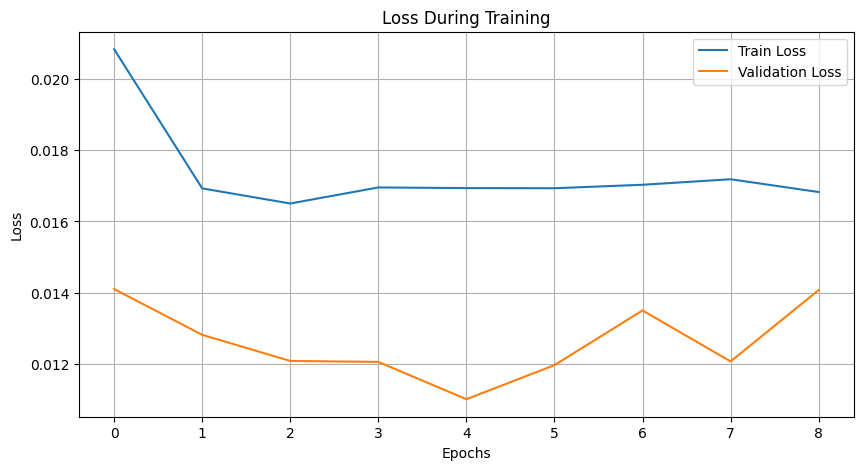

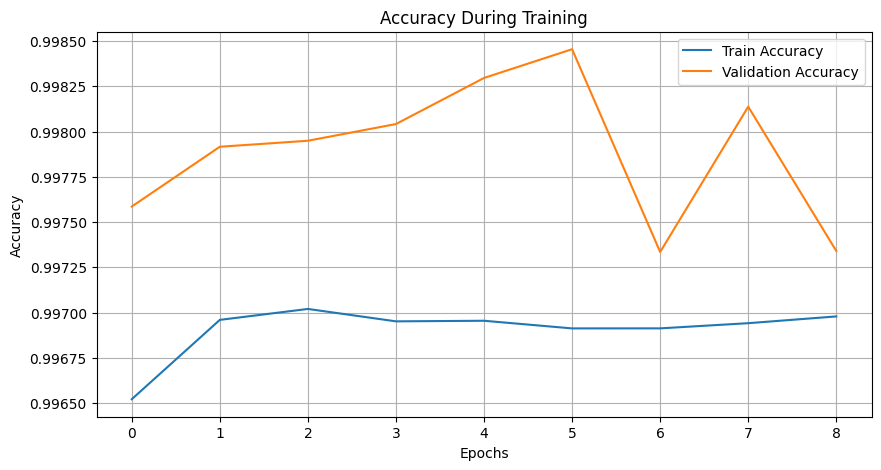

In [25]:
# Trainingsverlauf auslesen
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

# Verlust (Loss) plotten
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(len(train_loss)))
plt.show()

# Genauigkeit (Accuracy) plotten
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(range(len(train_accuracy)))
plt.show()

### Evaluierung des Modells auf dem Testdatensatz - Klassifikationsbericht und eine Konfusionsmatrix

In [26]:
# Vorhersagen auf dem Testdatensatz
y_pred_prob = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Klassifikationsbericht
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_classes)

16931/16931 ━━━━━━━━━━━━━━━━━━━━ 12s 718us/step
                              precision    recall  f1-score   support

                      BENIGN       1.00      1.00      1.00    296768
                 Botnet Ares       1.00      1.00      1.00     14292
              DDoS-LOIC-HTTP       1.00      1.00      1.00     28933
               DoS GoldenEye       1.00      1.00      1.00      2256
                    DoS Hulk       1.00      1.00      1.00    180316
               DoS Slowloris       0.98      0.93      0.96       849
Infiltration - NMAP Portscan       0.99      0.92      0.95      8938
              SSH-BruteForce       1.00      1.00      1.00      9419

                    accuracy                           1.00    541771
                   macro avg       1.00      0.98      0.99    541771
                weighted avg       1.00      1.00      1.00    541771



Visualisierung der Konfusionsmatrix

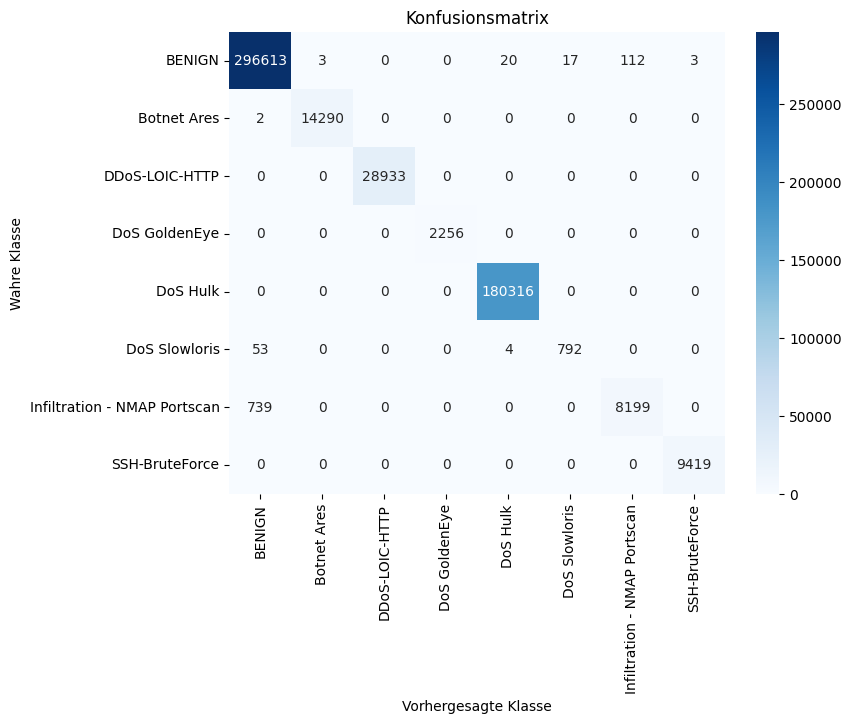

In [27]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()


### Speichern des Modells und der Vorverarbeitungsschritte

In [28]:
# Speichern des Modells
model.save('model.keras')

# Speichern des Label Encoders und Scalers
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']